# LangChain 核心工具接口再升级

> 官方博文：https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/

## LLM 应用生态中 Tools 的定位

在大语言模型（LLM）的上下文中，Tools（工具）是旨在由模型调用的实用程序。

它们具有明确的模式，可以作为输入提供给模型，并生成可以反馈给模型的输出。每当您希望模型控制代码的一部分或调用外部 API 时，就需要使用工具，这使得工具成为 LLM 应用的基本构建块。

下面，让我们深入了解如何在 LangChain 生态项目中集成、使用和管理工具。

## 在 LangChain 中快速应用工具

工具集成可能很复杂，通常需要手动工作，比如编写自定义封装器或接口。在 LangChain 中，我们从工具定义开始，降低了复杂性。

### 使用 bind_tools 导入普通函数 

现在可以将任何 Python 函数传递给 `ChatModel.bind_tools()`，这使得普通的 Python 函数可以直接用作工具。这简化了定义工具的方式，因为 LangChain 只需解析类型注释和文档字符串以推断所需的数据结构。

In [ ]:
# pip install -qU langchain>=0.2.8
from langchain.chat_models import init_chat_model

# Initialize the LLM with single-line init method
llm = init_chat_model(model="gpt-4o-mini", model_provider="openai", temperature=0)

/root/venv/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `init_chat_model` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [ ]:
from typing import List
from typing_extensions import TypedDict


class Address(TypedDict):
    street: str
    city: str
    state: str

# LangChain parses type annotations and docstrings to infer required schemas
def validate_user(user_id: int, addresses: List[Address]) -> bool:
    """Validate user using historical addresses.

    Args:
        user_id: (int) the user ID.
        addresses: Previous addresses.
    """
    return True

llm_bind_tools = llm.bind_tools([validate_user])

result = llm_bind_tools.invoke(
    "Could you validate user 123? They previously lived at "
    "123 Fake St in Boston MA and 234 Pretend Boulevard in "
    "Houston TX."
)


In [ ]:
from IPython.display import JSON

JSON(result.tool_calls)

<IPython.core.display.JSON object>

👆 LangSmith trace: https://smith.langchain.com/public/9fa8852a-99f8-4daa-b881-73575e5c942d/r

### 使用 as_tool 转换 Runnable

现在任何 LangChain Runnable 对象都可以通过 `as_tool` 方法被转换为一个工具，这使得重用现有的 Runnable 对象变得更加容易，甚至包括 Chain 和 Agent。

重用现有的 Runnable 对象可以减少重复性工作，并允许您更快地部署新功能。例如，下面我们将一个 LangGraph Agent 与另一个“用户信息代理”作为工具配对，使其能够将相关问题委托给辅助代理。

In [ ]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.prebuilt import create_react_agent


# Create a ReAct Agent that will ask questions about users
user_info_agent = create_react_agent(llm, [validate_user])


class Message(TypedDict):
    role: Literal["human"]
    content: str

# Convert the agent to a tool
agent_tool = user_info_agent.as_tool(
    arg_types={"messages": List[Message]},
    name="user_info_agent",
    description="Ask questions about users.",
)

# Create a ReAct agent that use the agentic tool
agent = create_react_agent(llm, [agent_tool])

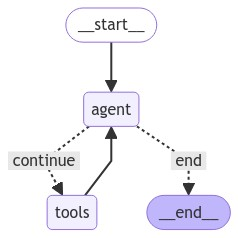

In [ ]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [ ]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Could you validate user 123 who once lived at 234 Pretend Boulevard in Houston TX")]}
print_stream(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Could you validate user 123 who once lived at 234 Pretend Boulevard in Houston TX
================================== Ai Message ==================================
Tool Calls:
  user_info_agent (call_fArhWAoNDOQN5emLJsuwcfvm)
 Call ID: call_fArhWAoNDOQN5emLJsuwcfvm
  Args:
    messages: [{'role': 'human', 'content': 'Please validate user 123 who once lived at 234 Pretend Boulevard in Houston TX.'}]
================================= Tool Message =================================
Name: user_info_agent

{'messages': [HumanMessage(content='Please validate user 123 who once lived at 234 Pretend Boulevard in Houston TX.', id='5772e490-e3eb-4bee-b970-a0310bc5e4ff'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NTI3uHXuod4FXANXvXNdfZYh', 'function': {'arguments': '{"user_id":123,"addresses":[{"street":"234 Pretend Boulevard","city":"Houston","state":"TX"}]}', 'name': 'validate_user'}, 'type

👆 LangSmith trace：https://smith.langchain.com/public/d4c3fc58-d536-4797-8d71-3ef6e95b6c9b/r

## 在 LangChain 中管理工具输入输出

### 隐藏工具待注入的参数

在某些情况下，我们并不希望工具的所有输入都由模型生成。例如，如果我们的工具需要某种类型的用户 ID，这个输入很可能来自我们代码的其他部分，而不是来自模型。

对于这些情况，LangChain 通过注释 [`InjectedToolArg`](https://api.python.langchain.com/en/latest/tools/langchain_core.tools.InjectedToolArg.html) 来指定工具的哪些输入不应该由模型生成。

In [ ]:
from typing import List

from langchain_core.tools import InjectedToolArg, tool
from typing_extensions import Annotated

user_to_pets = {}


@tool(parse_docstring=True)
def update_favorite_pets(
    pets: List[str], user_id: Annotated[str, InjectedToolArg]
) -> None:
    """Add the list of favorite pets.

    Args:
        pets: List of favorite pets to set.
        user_id: User's ID.
    """
    user_to_pets[user_id] = pets


@tool(parse_docstring=True)
def delete_favorite_pets(user_id: Annotated[str, InjectedToolArg]) -> None:
    """Delete the list of favorite pets.

    Args:
        user_id: User's ID.
    """
    if user_id in user_to_pets:
        del user_to_pets[user_id]


@tool(parse_docstring=True)
def list_favorite_pets(user_id: Annotated[str, InjectedToolArg]) -> None:
    """List favorite pets if any.

    Args:
        user_id: User's ID.
    """
    return user_to_pets.get(user_id, [])

In [ ]:
JSON(update_favorite_pets.get_input_schema().schema())

<IPython.core.display.JSON object>

In [ ]:
# Look at the tool call schema, which is what is passed to the model for tool-calling, user_id has been removed
JSON(update_favorite_pets.tool_call_schema.schema())

<IPython.core.display.JSON object>

In [ ]:
tools = [
    update_favorite_pets,
    delete_favorite_pets,
    list_favorite_pets,
]
llm_with_tools = llm.bind_tools(tools)

# When the model calls the tool, no user_id argument will be generated
ai_msg = llm_with_tools.invoke("my favorite animals are cats and parrots")
ai_msg.tool_calls

[{'name': 'update_favorite_pets',
  'args': {'pets': ['cats', 'parrots']},
  'id': 'call_av9rrp2FzABvnvp91kCqGyXU',
  'type': 'tool_call'}]

👆 LangSmith trace: https://smith.langchain.com/public/08ae3b8b-ea5f-414a-a094-249434f42551/r

### 增加工具输出时的携带

LangChain 中的工具现在可以通过 `ToolMessage` 中的 `artifact` 属性，来返回下游组件所需（但不应通过模型的输出内容返回）的结果，这为开发人员提供了更多对输出管理的控制。

In [ ]:
# pip install -qU "langchain-core>=0.2.19"

import random
from typing import List, Tuple

from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def generate_random_ints(min: int, max: int, size: int) -> Tuple[str, List[int]]:
    """Generate size random ints in the range [min, max]."""
    
    array = [random.randint(min, max) for _ in range(size)]
    content = f"Successfully generated array of {size} random ints in [{min}, {max}]."
    return content, array

In [ ]:
# Directly invoke the tool with plain arguments only gives us the content
generate_random_ints.invoke({"min": 0, "max": 9, "size": 10})

'Successfully generated array of 10 random ints in [0, 9].'

In [ ]:
# In order to get back both the content and the artifact, 
# we need to invoke our model with a ToolCall (which is a dictionary with "name", "args", "id" and "type" keys), 
# which has additional info needed to generate a ToolMessage like the tool call ID
generate_random_ints.invoke(
    {
        "name": "generate_random_ints",
        "args": {"min": 0, "max": 9, "size": 10},
        "id": "123",  # required
        "type": "tool_call",  # required
    }
)

ToolMessage(content='Successfully generated array of 10 random ints in [0, 9].', name='generate_random_ints', tool_call_id='123', artifact=[0, 4, 7, 3, 7, 1, 9, 9, 3, 0])

In [ ]:
llm_with_tools = llm.bind_tools([generate_random_ints])

ai_msg = llm_with_tools.invoke("generate 6 positive ints less than 25")
ai_msg.tool_calls

[{'name': 'generate_random_ints',
  'args': {'min': 1, 'max': 24, 'size': 6},
  'id': 'call_KILOJD61IfFjGeRt5QTe2yA9',
  'type': 'tool_call'}]

In [ ]:
# We can also use llm to generate a ToolMessage directly
generate_random_ints.invoke(ai_msg.tool_calls[0])

ToolMessage(content='Successfully generated array of 6 random ints in [1, 24].', name='generate_random_ints', tool_call_id='call_KILOJD61IfFjGeRt5QTe2yA9', artifact=[7, 21, 22, 18, 19, 2])

## 在 LangChain 中处理工具调用异常

工具可能会因为各种原因失败 —— 因此，实现回退机制并学习如何优雅地处理这些失败对于保持应用稳定性很重要。

### try...except 捕获并处理异常

处理错误最优雅的最简单方法是尝试捕获调用工具时发生的异常，并在错误时返回一个有帮助的消息。

In [ ]:
from langchain_core.tools import tool


@tool
def complex_tool(int_arg: int, float_arg: float, dict_arg: dict) -> int:
    """Do something complex with a complex tool."""
    return int_arg * float_arg

llm_with_tools = llm.bind_tools([complex_tool])

# Define chain to invoke the tool
chain = llm_with_tools | (lambda msg: msg.tool_calls[0]["args"]) | complex_tool

In [ ]:
from typing import Any

from langchain_core.runnables import Runnable, RunnableConfig

# Define a tool with try...except
def try_except_tool(tool_args: dict, config: RunnableConfig) -> Runnable:
    try:
        complex_tool.invoke(tool_args, config=config)
    except Exception as e:
        return f"Calling tool with arguments:\n\n{tool_args}\n\nraised the following error:\n\n{type(e)}: {e}"


chain = llm_with_tools | (lambda msg: msg.tool_calls[0]["args"]) | try_except_tool

# Invoke the chain
result = chain.invoke(
    "use complex tool. the args are 5, 2.1, empty dictionary. don't forget dict_arg"
)
print(result)

Calling tool with arguments:

{'int_arg': 5, 'float_arg': 2.1}

raised the following error:

<class 'pydantic.v1.error_wrappers.ValidationError'>: 1 validation error for complex_toolSchema
dict_arg
  field required (type=value_error.missing)


👆 LangSmith trace: https://smith.langchain.com/public/04472dae-c199-4562-9725-6c7115a92745/r

### 使用 Fallback 执行备用方案

在本例中，我们也可以尝试在工具调用错误时回退到一个更好的模型。例如，我们将回退到使用 `gpt-4-turbo` 而不是 `gpt-4o-mini` 的相同链路。

In [ ]:
chain = llm_with_tools | (lambda msg: msg.tool_calls[0]["args"]) | complex_tool

better_model = init_chat_model(model="gpt-4-turbo", model_provider="openai", temperature=0).bind_tools(
    [complex_tool], tool_choice="complex_tool"
)
better_chain = better_model | (lambda msg: msg.tool_calls[0]["args"]) | complex_tool

# Invoke the chain with a fallback
chain_with_fallback = chain.with_fallbacks([better_chain])

chain_with_fallback.invoke(
    "use complex tool. the args are 5, 2.1, empty dictionary. don't forget dict_arg"
)

10.5

👆 LangSmith trace: https://smith.langchain.com/public/d621f26e-4ef7-4571-81cd-7a21a4f8b05e/r

### 使用 Fallback 再次尝试运行

更进一步，我们可以尝试自动重新运行链路，传入异常，以便模型能够纠正其行为。

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, ToolCall, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class CustomToolException(Exception):
    """Custom LangChain tool exception."""

    def __init__(self, tool_call: ToolCall, exception: Exception) -> None:
        super().__init__()
        self.tool_call = tool_call
        self.exception = exception

# Define a tool with try...except
def tool_custom_exception(msg: AIMessage, config: RunnableConfig) -> Runnable:
    try:
        return complex_tool.invoke(msg.tool_calls[0]["args"], config=config)
    except Exception as e:
        raise CustomToolException(msg.tool_calls[0], e)


def exception_to_messages(inputs: dict) -> dict:
    exception = inputs.pop("exception")

    # Add historical messages to the original input, so the model knows that it made a mistake with the last tool call.
    messages = [
        AIMessage(content="", tool_calls=[exception.tool_call]),
        ToolMessage(
            tool_call_id=exception.tool_call["id"], content=str(exception.exception)
        ),
        HumanMessage(
            content="The last tool call raised an exception. Try calling the tool again with corrected arguments. Do not repeat mistakes."
        ),
    ]
    inputs["last_output"] = messages
    return inputs


# We add a last_output MessagesPlaceholder to our prompt which if not passed in doesn't
# affect the prompt at all, but gives us the option to insert an arbitrary list of Messages
# into the prompt if needed. We'll use this on retries to insert the error message.
prompt = ChatPromptTemplate.from_messages(
    [("human", "{input}"), ("placeholder", "{last_output}")]
)
chain = prompt | llm_with_tools | tool_custom_exception

# If the initial chain call fails, we rerun it withe the exception passed in as a message.
self_correcting_chain = chain.with_fallbacks(
    [exception_to_messages | chain], exception_key="exception"
)

In [ ]:
self_correcting_chain.invoke(
    {
        "input": "use complex tool. the args are 5, 2.1, empty dictionary. don't forget dict_arg"
    }
)

10.5

👆 LangSmith trace: https://smith.langchain.com/public/98850024-4fc9-4af0-9ef6-811d2f4c519c/r

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e6124301-0a3c-4c43-a70b-884a597351fa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>